**Installing PySpark**

In [1]:
!pip install pyspark pandas seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0bc070f0ad52a9b0496c5720e511649fbe3ab3806548738e3a04334da12d5299
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**Loading Libraries**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("Diabetes Clustering").getOrCreate()

In [6]:
# Load the dataset
df = spark.read.csv('/content/drive/MyDrive/DineshThapa/diabetes.csv', header=True, inferSchema=True)
df.show()

+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|              0|     1|       1|        1| 40|     1|     0|                   0|           0|     0|      1|                0|            1|          0|      5|      18|      15|       1|  0|  9|        4|     3|
|              0|     0|       0|        0| 25|     1|     0|                   0|           1|     0|      0|                0|            

In [7]:
# Assemble features into a single feature vector
assembler = VectorAssembler(
    inputCols=['HighBP', 'HighChol', 'BMI', 'Age', 'GenHlth', 'PhysHlth', 'MentHlth', 'Income'],
    outputCol='features'
)
df = assembler.transform(df)

In [8]:
# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [9]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette_scores = []

In [10]:
# Testing for k values from 2 to 9
for k in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k, seed=1)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print("Silhouette Score with k=", k, "is", silhouette)

Silhouette Score with k= 2 is 0.33598536837953213
Silhouette Score with k= 3 is 0.335301566583039
Silhouette Score with k= 4 is 0.29898999372046126
Silhouette Score with k= 5 is 0.310737743052562
Silhouette Score with k= 6 is 0.3278061517522477
Silhouette Score with k= 7 is 0.332749459239936
Silhouette Score with k= 8 is 0.35770186058595804
Silhouette Score with k= 9 is 0.3656818366675624


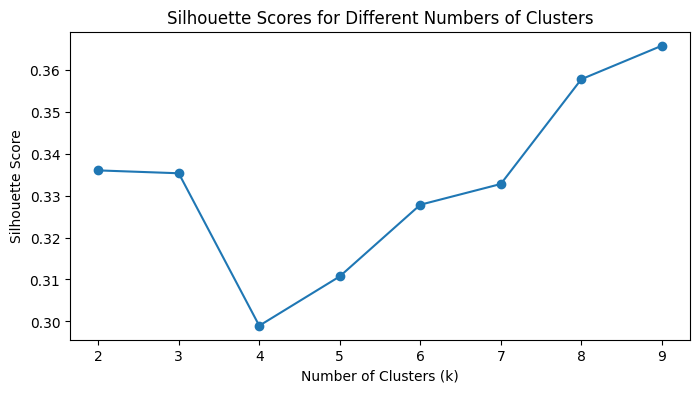

In [11]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

In [12]:
# Assuming the optimal k is found to be 4
optimal_k = 4
kmeans = KMeans(featuresCol='scaledFeatures', k=optimal_k, seed=1)
final_model = kmeans.fit(df)
predictions = final_model.transform(df)
centers = final_model.clusterCenters()

In [13]:
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 1.00460217  0.47082456  0.1194423   0.60832005  0.12618542 -0.30228074
 -0.26820068 -0.05975038]
[-0.52150418 -0.48043852  0.56332294 -0.91604541  0.22482326 -0.26050427
  0.3362643  -0.60882934]
[ 0.48567666  0.39239094  0.33323704  0.28228332  1.43098434  2.32162835
  1.21568977 -0.8164988 ]
[-0.79901709 -0.33180965 -0.43194064 -0.2398435  -0.6473842  -0.36851173
 -0.28861909  0.55131888]


In [14]:
# Convert predictions to Pandas DataFrame for visualization
pandas_df = predictions.select('scaledFeatures', 'prediction').toPandas()

In [15]:
# Create a PCA model to reduce dimensions for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(list(pandas_df['scaledFeatures']))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pandas_df['prediction']], axis=1)

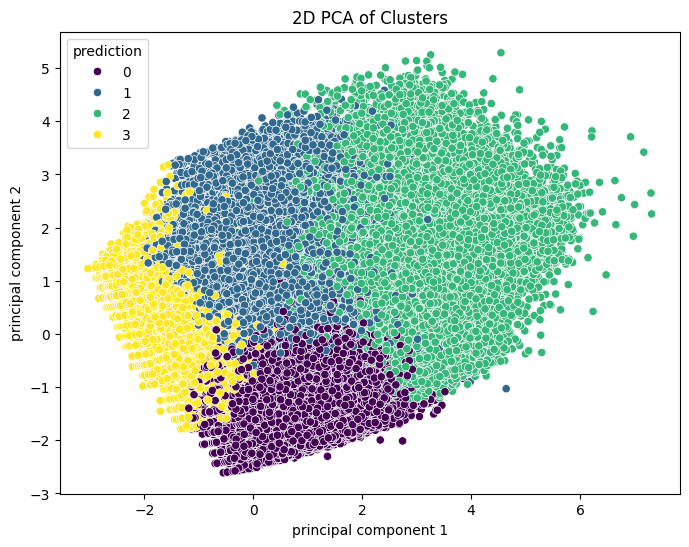

In [16]:
# Plotting the results
plt.figure(figsize=(8,6))
sns.scatterplot(x="principal component 1", y="principal component 2", hue="prediction", data=finalDf, palette='viridis')
plt.title('2D PCA of Clusters')
plt.show()
